# Keras implementation of https://junyanz.github.io/CycleGAN/
cite: https://github.com/tjwei/GANotebooks

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
λ = 100 if use_lsgan else 100

loadSize = 143
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [9]:
netDA = BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
First (Conv2D)               (None, None, None, 64)    3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, None, None, 128)   131072    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 128)   512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, None, None, 128)   0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, None, None, 256)   524288    
__________

In [10]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv_128 (Conv2D)               (None, 64, 64, 64)   3136        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 64, 64, 64)   0           conv_128[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, 32, 32, 128)  131072      leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
batch_norm

In [11]:
from keras.optimizers import RMSprop, SGD, Adam

In [12]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

In [13]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

In [14]:
loss_G = loss_GA+loss_GB+λ*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

In [15]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img


data = "Tony2Shia"
train_A = load_data('CycleGAN/{}/trainA/*.jpg'.format(data))
train_B = load_data('CycleGAN/{}/trainB/*.jpg'.format(data))

assert len(train_A) and len(train_B)

In [16]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [17]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

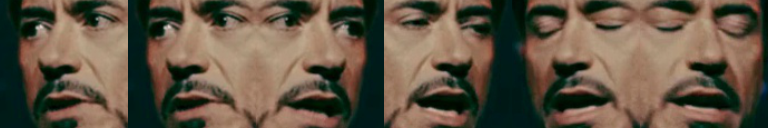

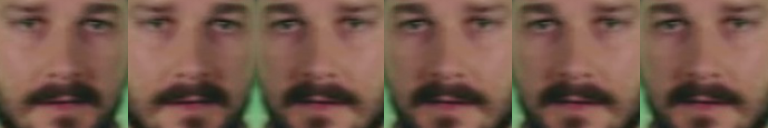

In [18]:
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B

In [19]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)

[0/51][50] Loss_D: 0.167754 0.162755 Loss_G: 0.751103 0.781829 loss_cyc 0.037639 35.48200583457947


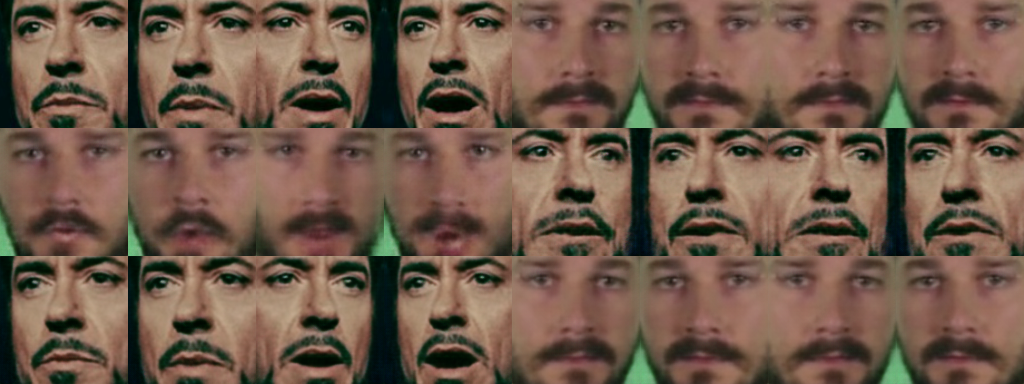

KeyboardInterrupt: 

In [26]:
import cv2
import time
from IPython.display import clear_output
t0 = time.time()
niter =51
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 50
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)

def G(fn_generate, X):
    r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
    return r.swapaxes(0,1)[:,:,0]

while epoch < niter: 
    epoch, A, B = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB
    
    #recordDA[epoch] = errDA   ########################
    #recordDB[epoch] = errDB    #######################

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    
    #recordGA[epoch] = errGA     #######################
    #recordGB[epoch] = errGB     #######################
    #recordCyc[epoch] = errCyc    #######################
    
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
                
                                 
        rA = G(cycleA_generate, A)
        rB = G(cycleB_generate, B)  
        
        #cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//GANotebooks-master//CycleGAN//{}//output//epoch//A//%d.bmp'.format(data) %(epoch), ((A[0,:,:,:]+1)/2*255).clip(0,255))
        #cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//GANotebooks-master//CycleGAN//{}//output//epoch//rA//%d.bmp'.format(data) %(epoch),((rA[0][0,:,:,:]+1)/2*255).clip(0,255))
        #cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//GANotebooks-master//CycleGAN//{}//output//epoch//B//%d.bmp'.format(data) %(epoch), ((B[0,:,:,:]+1)/2*255).clip(0,255))
        #cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//GANotebooks-master//CycleGAN//{}//output//epoch//rB//%d.bmp'.format(data) %(epoch),((rB[0][0,:,:,:]+1)/2*255).clip(0,255))
        
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A,B)        
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

# Save model

# 查看訓練結果(單張)

In [61]:
epoch, A, B = next(train_batch)

rA = G(cycleA_generate, A)
# OpenCV是BGR，所以要將RGB轉換成BGR
A = A[...,::-1]
rA = rA[...,::-1]
cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//A.jpg',((A[0,:,:,:]+1)/2*255).clip(0,255))
cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//rA.jpg',((rA[0][0,:,:,:]+1)/2*255).clip(0,255))


rB = G(cycleB_generate, B)
# OpenCV是BGR，所以要將RGB轉換成BGR
B = B[...,::-1]
rB = rB[...,::-1]
#cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//B.jpg',((B[0,:,:,:]+1)/2*255).clip(0,255))
#cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//rB.jpg',((rB[0][0,:,:,:]+1)/2*255).clip(0,255))


# Test (single image)

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [62]:
a = cv2.imread('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//trainA//frame_0121.jpg')
a = a[...,::-1]
a = cv2.resize(a, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
a = np.reshape(a, (1, 128, 128, 3))
a = a/255*2-1
rA = G(cycleA_generate, a)

A = ((a+1)/2*255).clip(0,255)
rA = ((rA+1)/2*255).clip(0,255)
#RGB to BGR (For OpenCV)
A = A[...,::-1]
rA = rA[...,::-1]
cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//frame_0121.jpg', A[0,:,:,:])
cv2.imwrite('C://Users//Administrator//Desktop//Deep learning//Deepfake//GAN//CycleGAN//Tony2Shia//rA_0121.jpg',rA[0][0,:,:,:])

True

Populating the interactive namespace from numpy and matplotlib


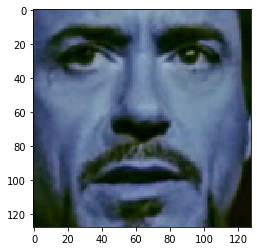

In [63]:
%pylab inline
imgplot = plt.imshow(A[0,:,:,:]/255)
plt.show()

In [6]:
a = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/car/input/4.jpg',0).astype(np.float32)
a = cv2.resize(a, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
b = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/car/input/4_rA.bmp',0).astype(np.float32)
b = cv2.resize(b, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
c = abs(a-b)

mean = np.mean(c)
std = np.std(c)
k =2
custom_threshold = np.zeros((imageSize, imageSize))
thre = mean+(k*std)

for xx in range(imageSize):
    for yy in range(imageSize):
        if c[xx, yy] >=thre:
            custom_threshold[xx, yy] = 255
        else:
            custom_threshold[xx, yy] = 0
            
cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/car/input/4_gray.jpg', c)
cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/car/input/4_th2.jpg', custom_threshold)

True

In [22]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
kernel = np.ones((2,2),np.uint8)
for i in range(niter):
    a = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/B/%d.bmp'.format(data) %(i),0).astype(np.float32)
    a = cv2.resize(a, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
    b = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/rB/%d.bmp'.format(data) %(i),0).astype(np.float32)
    b = cv2.resize(b, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
    c = abs(a-b)
    
    #c = c.astype('uint8')
    #ret2,th2 = cv2.threshold(c,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    mean = np.mean(c)
    std = np.std(c)
    k =2

    custom_threshold = np.zeros((imageSize, imageSize))

    thre = mean+(k*std)

    for xx in range(imageSize):
        for yy in range(imageSize):
            if c[xx, yy] >=thre:
                custom_threshold[xx, yy] = 255
            else:
                custom_threshold[xx, yy] = 0
    
    opening = cv2.morphologyEx(custom_threshold, cv2.MORPH_OPEN, kernel)
    opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
    
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/B_rB_gray/%d.bmp'.format(data) %(i), c)
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/B_rB_th2/%d.bmp'.format(data) %(i), custom_threshold)
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/B_morphology/%d.bmp'.format(data) %(i), opening)

In [23]:
for i in range(niter):
    a = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/A/%d.bmp'.format(data) %(i),0).astype(np.float32)
    a = cv2.resize(a, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
    b = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/rA/%d.bmp'.format(data) %(i),0).astype(np.float32)
    b = cv2.resize(b, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
    c = abs(a-b)
    
    #c = c.astype('uint8')
    #ret2,th2 = cv2.threshold(c,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    mean = np.mean(c)
    std = np.std(c)
    k = 2

    custom_threshold = np.zeros((imageSize, imageSize))

    thre = mean+(k*std)

    for xx in range(imageSize):
        for yy in range(imageSize):
            if c[xx, yy] >=thre:
                custom_threshold[xx, yy] = 255
            else:
                custom_threshold[xx, yy] = 0
    
    opening = cv2.morphologyEx(custom_threshold, cv2.MORPH_OPEN, kernel)
    opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)
    
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/A_rA_gray/%d.bmp'.format(data) %(i), c)
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/A_rA_th2/%d.bmp'.format(data) %(i), custom_threshold)
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/epoch/A_morphology/%d.bmp'.format(data) %(i), opening)

# Test

# OK 2 NG

In [38]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

os.chdir('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/OK'.format(data))
img_tensor = np.zeros((500, 128, 128, 3))
for i in range(0,500):
    img = cv2.imread('%d.bmp' %(i),cv2.IMREAD_COLOR)
    img_tensor[i] = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
    #img_tensor[i] = img[i].reshape(1,128,128,3)

img_tensor = img_tensor/255*2-1
img_tensor.shape

(500, 128, 128, 3)

In [40]:
rr = G(cycleA_generate, img_tensor)            #normal to defect
                
for i in range(len(img_tensor[:,0,0,0])):
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/OK2NG/%d.bmp'.format(data) %(i),((rr[0][i,:,:,:]+1)/2*255).clip(0,255))

In [42]:
for i in range(len(img_tensor[:,0,0,0])):
    a = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/OK/%d.bmp'.format(data) %(i),0).astype(np.float32)
    a = cv2.resize(a, (128, 128), interpolation=cv2.INTER_CUBIC)
    b = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/OK2NG/%d.bmp'.format(data) %(i),0).astype(np.float32)
    b = cv2.resize(b, (128, 128), interpolation=cv2.INTER_CUBIC)
    c = abs(a-b)
    
    #c = c.astype('uint8')
    #ret2,th2 = cv2.threshold(c,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    mean = np.mean(c)
    std = np.std(c)
    k =2.5

    custom_threshold = np.zeros((128, 128))

    thre = mean+(k*std)

    for xx in range(128):
        for yy in range(128):
            if c[xx, yy] >=thre:
                custom_threshold[xx, yy] = 255
            else:
                custom_threshold[xx, yy] = 0
    
    
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/OK_gray/%d.bmp'.format(data) %(i), c)
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/OK_th2/%d.bmp'.format(data) %(i), custom_threshold)

# NG 2 OK

In [56]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

os.chdir('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/NG'.format(data))
img_tensor = np.zeros((545, 128, 128, 3))
for i in range(0,545):
    img = cv2.imread('%d.bmp' %(i),cv2.IMREAD_COLOR)
    img_tensor[i] = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
    #img_tensor[i] = img[i].reshape(1,128,128,3)

img_tensor = img_tensor/255*2-1
img_tensor.shape

(545, 128, 128, 3)

In [57]:
rr = G(cycleB_generate, img_tensor)            #defect to normal
                
for i in range(len(img_tensor[:,0,0,0])):
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/NG2OK/%d.bmp'.format(data) %(i),((rr[0][i,:,:,:]+1)/2*255).clip(0,255))

In [58]:
for i in range(len(img_tensor[:,0,0,0])):
    a = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/NG/%d.bmp'.format(data) %(i),0).astype(np.float32)
    a = cv2.resize(a, (128, 128), interpolation=cv2.INTER_CUBIC)
    b = cv2.imread('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/NG2OK/%d.bmp'.format(data) %(i),0).astype(np.float32)
    b = cv2.resize(b, (128, 128), interpolation=cv2.INTER_CUBIC)
    c = abs(a-b)
    
    c = c.astype('uint8')
    ret2,th2 = cv2.threshold(c,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #mean = np.mean(c)
    #std = np.std(c)
    #k =2.5

    #custom_threshold = np.zeros((128, 128))

    #thre = mean+(k*std)

    #for xx in range(128):
        #for yy in range(128):
            #if c[xx, yy] >=thre:
                #custom_threshold[xx, yy] = 255
            #else:
                #custom_threshold[xx, yy] = 0
    
    
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/NG_gray/%d.bmp'.format(data) %(i), c)
    cv2.imwrite('/home/mv2428/Desktop/PCB_positioning/GANotebooks-master/CycleGAN/{}/output/NG_th2/%d.bmp'.format(data) %(i), th2)